In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords , wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
initial_dataset = pd.read_csv('isear.csv')
initial_dataset.head()

,Emotions,Statements
0,fear,Every time I imagine that someone I love or I ...
1,anger,When I had been obviously unjustly treated and...
2,sadness,When I think about the short time that we live...
3,disgust,At a gathering I found myself involuntarily si...
4,shame,When I realized that I was directing the feeli...


In [4]:
# Fetching all the emotions and it's count present in the dataset
emotions = initial_dataset['Emotions'].value_counts()
print(emotions)
print(f"Total entries in the dataset : {emotions.sum()}")

Emotions
anger      1094
sadness    1094
disgust    1094
shame      1094
fear       1093
guilt      1091
joy        1091
Name: count, dtype: int64
Total entries in the dataset : 7651


In [5]:
# To check if there are any null values present in the dataset
print(initial_dataset.isnull().sum())

Emotions      0
Statements    0
dtype: int64


In [6]:
# To check if there are any duplicate values present in the dataset
print(initial_dataset["Statements"].duplicated().sum())

# Displaying all the duplicates present in the dataset
duplicates = initial_dataset[initial_dataset.duplicated()]

#Print all the unique duplicates present in the dataset
print(duplicates.value_counts())

163
Emotions  Statements                                                                     
shame     [ No response.]                                                                    20
guilt     [ No response.]                                                                    13
disgust   [ No response.]                                                                    12
sadness   [ No response.]                                                                    11
          When my grandfather died.                                                           7
anger     [ No response.]                                                                     7
sadness   When my grandmother died.                                                           5
fear      [ No response.]                                                                     4
shame     Not doing well in the examn.                                                        3
sadness   When my grandmother passed away.

In [7]:
null_responses = ["[ No response.]","[ Do not know.]","NO RESPONSE.","Doesn't apply.","Does not apply.","[ Can not think of anything just now.]" , "[ No description.]" , "[ Never felt the emotion.]" , "[ I have never felt this emotion.]" , "[ Never experienced.]" , "[ Never.]" , "[ Do not remember any incident.]"]

# Removing the rows containing null responses
null_removed_dataset = initial_dataset[~initial_dataset['Statements'].isin(null_responses)]

# To check if there are any null values present in the dataset
print(null_removed_dataset.isnull().sum())

Emotions      0
Statements    0
dtype: int64


In [8]:
# Fetching all the emotions and it's count present in the dataset
updated_emotions = null_removed_dataset['Emotions'].value_counts()
print(updated_emotions)
print(f"Total entries in the dataset : {updated_emotions.sum()}")

Emotions
joy        1087
fear       1085
anger      1084
sadness    1082
disgust    1076
guilt      1067
shame      1063
Name: count, dtype: int64
Total entries in the dataset : 7544


In [9]:
# To check if there are any duplicate values present in the dataset
print(null_removed_dataset["Statements"].duplicated().sum())

# Displaying all the duplicates present in the dataset
updated_duplicates = null_removed_dataset[null_removed_dataset.duplicated()]

#Print all the unique duplicates present in the dataset
print(updated_duplicates.value_counts())

68
Emotions  Statements                                                                     
sadness   When my grandfather died.                                                          7
          When my grandmother died.                                                          5
shame     Not doing well in the examn.                                                       3
sadness   When my grandmother passed away.                                                   3
          When my dog died.                                                                  2
          When my father died.                                                               2
joy       Getting into this university to do medicine.                                       2
          When I was admitted to the University.                                             2
shame     Failing an examn.                                                                  2
fear      Before the examn.                         

In [10]:
print(updated_duplicates)

     Emotions                                         Statements
715   sadness                        When my girlfriend left me.
770   sadness                          When my grandmother died.
1021  sadness                       The death of my grandmother.
1266  sadness                          When my grandfather died.
1345  sadness                When my grandmother died of cancer.
1546  sadness                          When my grandmother died.
2087  sadness                               When my father died.
2277  sadness                          When my grandmother died.
2506  sadness                                  When my dog died.
2548  sadness                          When my grandmother died.
2757  sadness                          When my grandfather died.
2843      joy                              When my son was born.
2899      joy             When I was admitted to the University.
2950      joy             When I was admitted to the University.
4176  sadness            

Emotions
joy        14.408802
fear       14.382291
anger      14.369035
sadness    14.342524
disgust    14.262990
guilt      14.143690
shame      14.090668
Name: count, dtype: float64


<Axes: xlabel='Emotions', ylabel='count'>

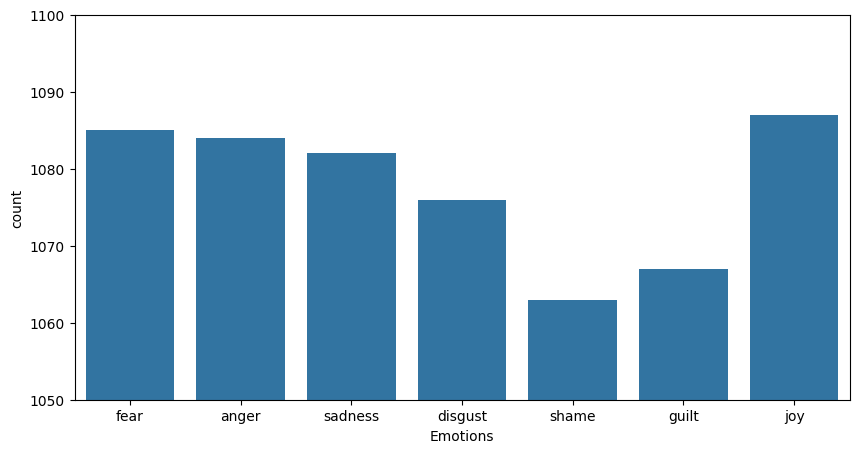

In [11]:
# Percentage of emotions present in the dataset
emotions_percentage = updated_emotions/sum(updated_emotions)*100
print(emotions_percentage)

# Plot the emotions vs it's count as a bar plot and keep the scale of count from 1050 to 1100
plt.figure(figsize=(10,5))
plt.ylim(1050, 1100)
sns.countplot(x='Emotions', data=null_removed_dataset)

In [26]:
# Finding the stop words for each statement
# copy_dataset = null_removed_dataset.copy()
# copy_dataset['Statements'] = copy_dataset['Statements'].str.lower()
# stop_words = set(stopwords.words('english'))
# copy_dataset['stop_words'] = copy_dataset['Statements'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
# copy_dataset.head()

,Emotions,Statements,stop_words
0,fear,every time i imagine that someone i love or i ...,6
1,anger,when i had been obviously unjustly treated and...,8
2,sadness,when i think about the short time that we live...,19
3,disgust,at a gathering i found myself involuntarily si...,10
4,shame,when i realized that i was directing the feeli...,22


In [12]:
# Data Cleaning

# def spell_check(text):
#     # Spellcheker object
#     spell = SpellChecker()

#     # Load a custom dictionary or add custom words to the dictionary
#     custom_words = ["domain-specific", "vocabulary"]
#     spell.word_frequency.load_words(custom_words)

#     # Set a threshold for accepting suggestions based on word frequency
#     spell.distance = 2  # Set the Levenshtein distance threshold

#     # Example sentence with misspellings
#     sentence = "Ths sentance has some misspellings and i am unhapy."

#     # Tokenize the sentence into words
#     words = sentence.split()

#     # Correct each word in the sentence
#     corrected_words = []
#     for word in words:
#         # Check if the word is misspelled
#         if spell.unknown([word]):
#             # Correct the misspelled word
#             corrected_word = spell.correction(word)
#             corrected_words.append(corrected_word)
#         else:
#             # Keep the original word if it's correctly spelled
#             corrected_words.append(word)

#     # Join the corrected words back into a sentence
#     corrected_sentence = " ".join(corrected_words)
#     print("Original sentence:", sentence)
#     print("Corrected sentence:", corrected_sentence)


def convert_to_lower_case(text):
    return text.lower()

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_stop_words(text):
    return ' '.join([word for word in str(text).split() if word not in stop_words])

def get_wordnet_pos(word):
    # Map POS tag to first character that the lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)])


def cleaned_sentence(text):
    # text = spell_check(text)
    text = convert_to_lower_case(text)
    text = remove_special_characters(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_stop_words(text)
    text = lemmatization(text)
    return text

text1 = "Every time I imagine that someone I love or I could contact a serious illness, even death."
print("Original Sentence : ", text1)
print("Number of words in the Sentence : ",len(text1.split()))
cleaned1 = cleaned_sentence(text1)
print("Cleaned Sentence : ", cleaned1)
print("Stop words present in the Sentence : ",([word for word in text1.split() if word in stop_words]))

Original Sentence :  Every time I imagine that someone I love or I could contact a serious illness, even death.
Number of words in the Sentence :  17
Cleaned Sentence :  every time imagine someone love could contact serious illness even death
Stop words present in the Sentence :  ['that', 'or', 'a']


In [13]:
text2 = "I am happy this shit finally got done, ; I can't stop crying  & I will start singing. !"
print("Original Sentence : ", text2)
print("Number of words in the Sentence : ",len(text2.split()))
cleaned2 = cleaned_sentence(text2)
print("Cleaned Sentence : ", cleaned2)
print("Stop words present in the Sentence : ",([word for word in text2.split() if word in stop_words]))

Original Sentence :  I am happy this shit finally got done, ; I can't stop crying  & I will start singing. !
Number of words in the Sentence :  19
Cleaned Sentence :  happy shit finally get do cant stop cry start sing
Stop words present in the Sentence :  ['am', 'this', 'will']


In [14]:
text3 = "I am not happy this shit isn't done, ; I can't stop crying  & I will not start singing. !"
print("Original Sentence : ", text3)
print("Number of words in the Sentence : ",len(text3.split()))
cleaned3 = cleaned_sentence(text3)
print("Cleaned Sentence : ", cleaned3)
print("Stop words present in the Sentence : ",([word for word in text3.split() if word in stop_words]))

Original Sentence :  I am not happy this shit isn't done, ; I can't stop crying  & I will not start singing. !
Number of words in the Sentence :  20
Cleaned Sentence :  happy shit isnt do cant stop cry start sing
Stop words present in the Sentence :  ['am', 'not', 'this', "isn't", 'will', 'not']


In [15]:
# Data Processing
# The train set will be used to train our deep learning models
# The test set will be used to evaluate how well our model performs

X = list()
sentences = list(null_removed_dataset['Statements'])
for sen in sentences:
    X.append(cleaned_sentence(sen))

y = null_removed_dataset['Emotions']

X_train , X_test , y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=42)

X_train

['sit restaurant friend knew meantime girlfriend must come flat found door close',
 'see dead dog road',
 'one night dinner nephew naughty quarrel parent regret nephew two year old tolerate quarrel make father think child may take care future slip tongue make realize father keep thought still angry drop bowl chopstick go kitchen drink tea ran side house',
 'met girlfriend see several month saw discotheque like discotheque go knew would meet',
 'felt fear car travel direct towards precipice along road',
 'walk church roommate bum told u call police start follow u',
 'brother accuse undeservedly parent guilty mislead wife',
 'get hug someone love',
 'nearly get fiancee pregnant',
 'christmas day drunk man come house without shirt dansed spoke nonsense behave stupidly',
 'noisy guest arrive hotel slightly irritated earlier night try sleep party go yell want sleep get early next day',
 'move nijmegen study soon mother admit hospital cardiac compliants knew move important reason',
 'enter u

In [16]:
# Encoding the Labels and printing
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(set(y_train))

{0, 1, 2, 3, 4, 5, 6}


In [17]:
# Converting to matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [18]:
# Embedding layer expects the words to be in numeric form
# Tokenizing the words
# Method fit_on_text trains the tokenizer on the training data
# Method texts_to_sequences converts the sentences to their numeric form

combined_data = X_train + X_test
tokenizer = Tokenizer(oov_token='UNK')

# Now we convert the list to a series and use tokenizer.fit_on_texts()
combined_series = pd.Series(combined_data)
tokenizer.fit_on_texts(combined_series)

print(tokenizer.word_index['death'])
print(tokenizer.document_count)

126
7544


In [19]:
# Converting the sentence to a list of integers
tokenizer.texts_to_sequences(X_train[0].split())

[[194], [488], [2], [129], [2206], [53], [748], [8], [366], [43], [212], [46]]

In [20]:
# Converting the list of integers to a matrix
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
tokenizer.texts_to_matrix(X_train[0].split()).shape

(12, 7185)

In [22]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

maxlength = max([len(t) for t in null_removed_dataset['Statements']])
maxlength

877

In [23]:
# Padding the sequences
X_train = pad_sequences(sequences_train, maxlen=maxlength, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlength, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary Size : {vocabSize}")

Vocabulary Size : 7185


In [24]:
sequences_train[0]

[194, 488, 2, 129, 2206, 53, 748, 8, 366, 43, 212, 46]

In [25]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [26]:
# Word Embedding

path_to_glove_file = r"C:\Users\vedan\Downloads\glove.42B.300d\glove.42B.300d.txt"
embeddings_index = {}
num_tokens = vocabSize
embedding_dim = 300
hits = 0
misses = 0

In [27]:
# Reading word vectors from the file
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

Found 1917494 word vectors.


In [31]:
# Assign word vectors to our dictionay / vocabulary
embedding_matrix = np.zeros((num_tokens , embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 13480 words (888 misses)


In [32]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13865   ,  0.025676  , -0.14685   , ...,  0.17471001,
        -0.025477  ,  0.10403   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.42024001,  0.072844  , -0.10694   , ...,  0.2816    ,
        -0.20145001,  0.043875  ],
       [ 0.075309  , -0.21071   ,  0.53218001, ...,  0.26402   ,
        -0.92218   ,  0.15505999]])

In [34]:
embedding_matrix.shape

(7185, 300)

In [35]:
print("Shape of embedding matrix : ", embedding_matrix.shape)
print("Expected shape by Embedding layer : ", vocabSize, embedding_dim)


# adam = Adam(learning_rate=0.005)

# model = Sequential()
# model.add(Embedding(7184, embedding_dim , embedding_matrix ,trainable=False))
# model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
# model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
# model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Dense(7, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# model.summary()

Shape of embedding matrix :  (7185, 300)
Expected shape by Embedding layer :  7185 300
